#Transfer Learning with Tensorflow Part - 1: Feature Extraction

##Downloading and becoming one with the data

In [ ]:
import zipfile

#Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

#unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-07-05 05:14:53--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.69.128, 64.233.183.128, 173.194.193.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   123MB/s    in 1.3s    

2023-07-05 05:14:54 (123 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [ ]:
#How many images in each folder?
import os

#Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent

##Creating data loaders (preparing the data)

- Use the ImageDataGenerator class to load in our images in batches.

In [ ]:
#Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/225.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images: ")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images: ")
test_data=test_datagen.flow_from_directory(test_dir,
                                          target_size=IMAGE_SHAPE,
                                          batch_size=BATCH_SIZE,
                                          class_mode="categorical")

Training images: 
Found 750 images belonging to 10 classes.
Testing images: 
Found 2500 images belonging to 10 classes.


##Setting up call backs(things to run whilst our model trains)

callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with **Tensorboard Callbacks**
* Model checkpoint with the **ModelCheckPoint callback**
* Stopping a model from training (before it trains too long and overfits) with the **EarlyStopping callback**

In [ ]:
#Create tensorboard callback(functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" +datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving Tensorboard log files to: {log_dir}")
  return tensorboard_callback

##Creating models using Tensorflow Hub

https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [ ]:
#Compare the models

#Resnet 50 v2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

#original: Original efficientNetB0 feature vector(version1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
#import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

In [ ]:
#Lets make a create_model() function to create a model from a url

def create_model(model_url, num_classes=10):
  """
  Takes a tensorflow hub url and creates a keras sequential model with it.

  Args:
    model_url(str): A tensorflow hub feature extraction URL.
    num_classes(int): Number of output neurons in the output layer,
    should be equal to number of target classes, default 10.

  Returns:
    An uncompiled keras sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """

  #Download the pre-trained model
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extraction_Layer",
                                           input_shape=IMAGE_SHAPE+(3,))

  #create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])
  return model

##Creating and testing ResNet TensorFlow Hub Feature Extraction Model

In [ ]:
#create our resnet model
resnet_model = create_model(resnet_url,
                            num_classes = train_data_10_percent.num_classes)

In [ ]:
#compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files


Saving Tensorboard log files to: tensorflow_hub/resnet50V2/20230705-053532
Epoch 1/5
24/24 [==============================] - 40s 1s/step - loss: 1.9696 - accuracy: 0.3293 - val_loss: 1.2599 - val_accuracy: 0.6012
Epoch 2/5
24/24 [==============================] - 25s 1s/step - loss: 0.8908 - accuracy: 0.7360 - val_loss: 0.8850 - val_accuracy: 0.7112
Epoch 3/5
24/24 [==============================] - 19s 816ms/step - loss: 0.6142 - accuracy: 0.8187 - val_loss: 0.7809 - val_accuracy: 0.7448
Epoch 4/5
24/24 [==============================] - 18s 762ms/step - loss: 0.4846 - accuracy: 0.8800 - val_loss: 0.7191 - val_accuracy: 0.7652
Epoch 5/5
24/24 [==============================] - 19s 796ms/step - loss: 0.3990 - accuracy: 0.8933 - val_loss: 0.6927 - val_accuracy: 0.7736


In [ ]:
#Create a function to flow the loss curves
import matplotlib.pyplot as plt

#Plo the validation and training curves
def plot_loss_curves(history):
  """
  Returns seperate loss curves for training and validation metrics.

  Args:
    history: Tensorflow History object.

  Returns:
    plots of training/validation loss and accuracy metrics.
  """

  loss = history.history["loss"]
  val_loss  = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  #Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  #plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

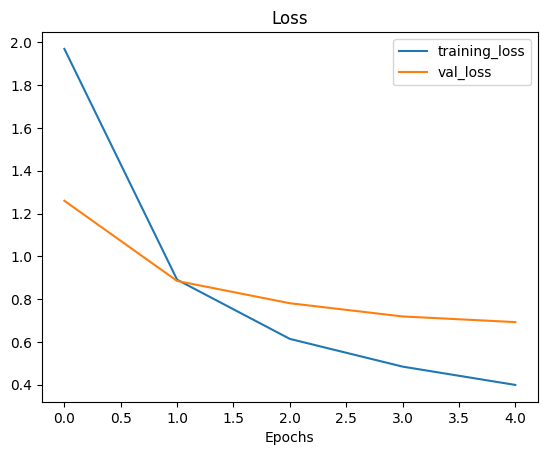

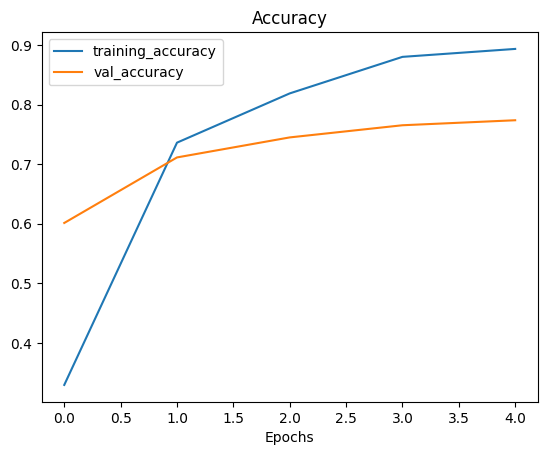

In [ ]:
plot_loss_curves(resnet_history)

##Creating and Testing EfficientNetB0 Tensorflow Hub Feature Extraction model

In [ ]:
#Compile our efficientnet model
efficientnet_model = create_model(efficientnet_url,
                               num_classes = train_data_10_percent.num_classes)

In [ ]:
#compile our efficientnet model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

In [ ]:
#Fit the model
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data = test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name = "efficientnetb0")])

Saving Tensorboard log files to: tensorflow_hub/efficientnetb0/20230705-060657
Epoch 1/5
24/24 [==============================] - 39s 1s/step - loss: 1.8380 - accuracy: 0.4267 - val_loss: 1.2880 - val_accuracy: 0.7220
Epoch 2/5
24/24 [==============================] - 21s 888ms/step - loss: 1.0686 - accuracy: 0.7613 - val_loss: 0.8805 - val_accuracy: 0.8076
Epoch 3/5
24/24 [==============================] - 19s 810ms/step - loss: 0.7734 - accuracy: 0.8427 - val_loss: 0.7144 - val_accuracy: 0.8380
Epoch 4/5
24/24 [==============================] - 20s 844ms/step - loss: 0.6218 - accuracy: 0.8733 - val_loss: 0.6310 - val_accuracy: 0.8448
Epoch 5/5
24/24 [==============================] - 19s 836ms/step - loss: 0.5271 - accuracy: 0.8867 - val_loss: 0.5768 - val_accuracy: 0.8528


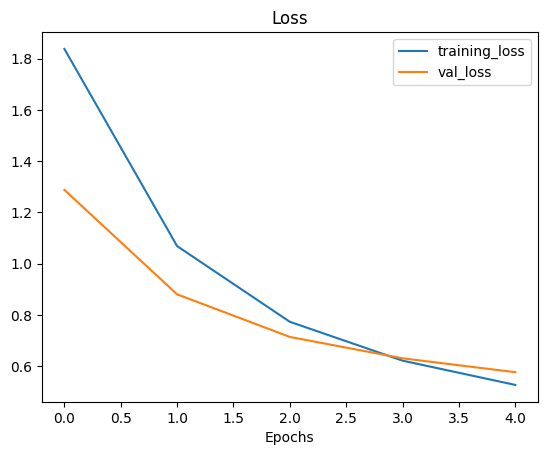

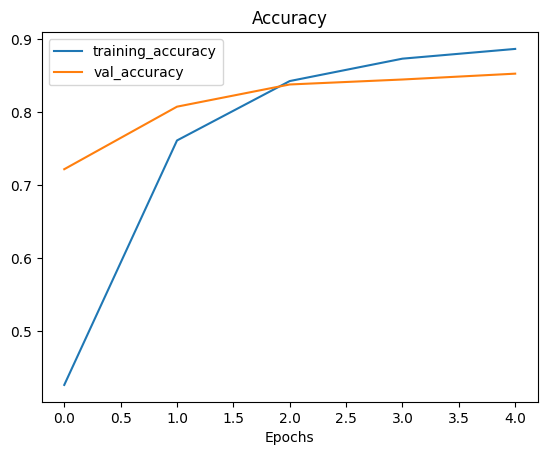

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
efficientnet_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_Layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
resnet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_Layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
#How many layers does our efficientnetb0 feature extractor have?
len(efficientnet_model.layers[0].weights)

309

##Different types of Transfer learning
 - "As is" transfer learning - using an existing model with no changes what so ever(eg.using imageNet model on 1000 ImageNet classes, none of your own)
 - "Feature extraction" transfer learning - use the pre-learned patterns of an existing model(eg. EfficientNetB0 trained on ImageNet) and adjust the output layer of your own problem(eg. 1000 classes -> 10 classes of food)
 - "Fine-tuning" transfer learning - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers(including new output layers)

##Compare our models results using tensorboard

In [ ]:
#Upload Tensorboard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/\
  --name "EfficientNetB0 vs. ResNet50V2"\
  --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data"\
  --one_shot

2023-07-05 06:47:53.121779: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/usr/local/lib/python3.10/dist-packages/tensorboard/main.py", line 46, in run_main
  File "/usr/local/lib/python3.10/dist-packages/absl/app

In [ ]:
# delete an experiment
# !tensorboard dev delete --experiment_id_dQBrpdwIRgS2qI0Andv8Yg

In [ ]:
#Confirm the deletion by rechecking what experiments you have left
# !tensorboard dev list